# Analysis of Airbnb Listings and Availability in New York City

## Introduction
This notebook provides data exploration and in-depth analysis of Airbnb listings and their availability across New York City. The analysis aims to uncover insights related to the most common types of listings, their pricing, and availability trends. 

## Data Loading and Overview

In [1]:
# Load packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Load datasets
calendar_df = pd.read_csv('calendar_nyc.csv')
listings_df = pd.read_csv('listings_nyc.csv')

In [ ]:
# Print dataset shapes
print(f'calendar:{calendar_df.shape}') 
print(f'listing:{listings_df.shape}')

In [ ]:
calendar_df.head()

In [ ]:
calendar_df.info(show_counts=True)

In [ ]:
listings_df.head()

In [ ]:
# listing_df contains listing features, host information, reviews and some pre-processed calculated fileds
listings_df.info()

## Data Cleaning and Preprocessing

In [3]:
# convert to datetime 
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'])
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [4]:
# convert price to numeric
calendar_df['price'] = (calendar_df['price'].str.replace('$','')
                    .str.replace(',','')
                    .astype('float'))

calendar_df['adjusted_price'] = (calendar_df['adjusted_price'].str.replace('$','')
                    .str.replace(',','')
                    .astype('float'))

In [5]:
# price should not be 0.
calendar_df = calendar_df[calendar_df['price']!= 0]

In [6]:
# minimum_nights should be smaller than maximum_nights
listings_df = listings_df[listings_df['minimum_nights']<=listings_df['maximum_nights']]

In [7]:
# Check for first review date after last review
listings_df[listings_df['first_review']>listings_df['last_review']].size

0

In [ ]:
# Check for missing data in key columns
print(calendar_df['price'].isna().sum())
print(calendar_df['minimum_nights'].isna().sum())
print(calendar_df['maximum_nights'].isna().sum())
print(listings_df['price'].isna().sum())
print(listings_df['minimum_nights'].isna().sum())
print(listings_df['maximum_nights'].isna().sum())
# Use price in calendar_df and minimum_nights & maximum_nights in listings_df

In [8]:
# Check adjusted_price
adjusted_price_diff = sum(calendar_df[~calendar_df['adjusted_price'].isna()]['adjusted_price'] - calendar_df['price'])
print(f'Total adjusted price difference: {adjusted_price_diff}')

Total adjusted price difference: nan


In [9]:
# Check price fluctuations
price_summary = calendar_df.groupby('listing_id')['price'].agg(['min', 'mean', 'max']).reset_index()
print(f'Number of listings with price fluctuations: {price_summary[price_summary["min"] != price_summary["max"]].size}')

Number of listings with price fluctuations: 0


In [21]:
# Check number of listings in each df
print(f'Number of unique `listing_id` in calendar: {calendar_df["listing_id"].nunique()}')
print(f'Number of unique `id` in listings: {listings_df["id"].nunique()}')

Number of unique `listing_id` in calendar: 37537
Number of unique `id` in listings: 37540


In [26]:
# Check unmatched 
c_id = calendar_df['listing_id']
l_id = listings_df['id']
missing_id1 = listings_df[~listings_df['id'].isin(c_id)]['id']
missing_id2 = calendar_df[~calendar_df['listing_id'].isin(l_id)]['listing_id']
print(f'Number of unmatched `id`: {missing_id1.nunique() + missing_id2.nunique()}')

Number of unmatched `id`: 5


In [7]:
# Subset data for relevant analysis
listing = listings_df[['id','name','listing_url',
       'description', 'neighborhood_overview',
       'neighbourhood_cleansed','neighbourhood_group_cleansed','latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text',
       'bedrooms','amenities','minimum_nights','maximum_nights',
      'availability_30','availability_60','availability_90','availability_365',
        'number_of_reviews', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','host_id','host_name','host_since', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate','instant_bookable',
       'host_is_superhost', 'host_verifications','license',
       'host_has_profile_pic', 'host_identity_verified','calculated_host_listings_count']]

In [ ]:
listing.info()

In [8]:
# Handle missing and outlier data in bedrooms and bathrooms
listing_size_info = listing[['name','description','accommodates','bathrooms','bathrooms_text','bedrooms']]
listing_size_info.head()

,name,description,accommodates,bathrooms,bathrooms_text,bedrooms
0,Lovely room 2 windows tv work desk ac included,"Lovely vocation room, has work desk , tv, 2 wi...",1,1.0,1 shared bath,1.0
1,Room by Sunny & Bay! Sunset Park & Bay Ridge,Cozy room in a charming Sunset Park apartment....,1,1.0,1 shared bath,1.0
2,Private Room in Luxury Apartment,NaN,2,1.0,1 shared bath,1.0
3,Modern renovated huge apartment,NaN,8,2.0,2 baths,3.0
4,Summertime Park Slope townhouse,425 10th Street is what dreams are made of! S...,5,2.5,2.5 baths,4.0


In [9]:
listing['bathrooms_text'] = listing['bathrooms_text'].fillna('0')
listing['bedrooms'] = listing['bedrooms'].fillna(0)

In [10]:
listing_size_info['bathrooms_text'].unique()

array(['1 shared bath', '2 baths', '2.5 baths', '1 private bath',
       '1 bath', nan, '1.5 baths', '0 shared baths', '4 baths',
       '2 shared baths', '1.5 shared baths', 'Half-bath', '0 baths',
       '2.5 shared baths', '3 baths', '3.5 baths', '5 baths',
       '3 shared baths', '4 shared baths', '7.5 baths', '4.5 baths',
       'Private half-bath', '5 shared baths', '6 shared baths',
       '10.5 baths', 'Shared half-bath', '6 baths', '4.5 shared baths',
       '3.5 shared baths', '5.5 baths', '7 baths', '6.5 baths',
       '15.5 baths', '11.5 baths'], dtype=object)

In [11]:
listing.loc[listing['bathrooms_text'].str.contains('half-bath',case=False,na=False), 'bathrooms_text'] = '0.5'

In [12]:
listing['bathrooms_cnt'] = listing['bathrooms_text'].str.split(' ').str[0].astype('float')

In [13]:
# Identify unreasonable bedroom-bathroom combinations
bed_bath_combinations = listing['bedrooms'].astype(str) + '_' + listing['bathrooms_cnt'].astype(str)
sorted(set(bed_bath_combinations))

['0.0_0.0',
 '0.0_0.5',
 '0.0_1.0',
 '0.0_1.5',
 '0.0_2.0',
 '0.0_2.5',
 '0.0_3.0',
 '0.0_6.0',
 '1.0_0.0',
 '1.0_0.5',
 '1.0_1.0',
 '1.0_1.5',
 '1.0_10.5',
 '1.0_11.5',
 '1.0_2.0',
 '1.0_2.5',
 '1.0_3.0',
 '1.0_3.5',
 '1.0_4.0',
 '1.0_4.5',
 '1.0_5.0',
 '1.0_6.0',
 '10.0_1.0',
 '14.0_15.5',
 '15.0_6.0',
 '16.0_7.0',
 '2.0_0.0',
 '2.0_0.5',
 '2.0_1.0',
 '2.0_1.5',
 '2.0_2.0',
 '2.0_2.5',
 '2.0_3.0',
 '2.0_3.5',
 '2.0_4.5',
 '3.0_0.0',
 '3.0_0.5',
 '3.0_1.0',
 '3.0_1.5',
 '3.0_2.0',
 '3.0_2.5',
 '3.0_3.0',
 '3.0_3.5',
 '3.0_4.0',
 '3.0_4.5',
 '3.0_5.0',
 '3.0_5.5',
 '4.0_0.0',
 '4.0_1.0',
 '4.0_1.5',
 '4.0_2.0',
 '4.0_2.5',
 '4.0_3.0',
 '4.0_3.5',
 '4.0_4.0',
 '4.0_4.5',
 '4.0_5.0',
 '4.0_6.0',
 '4.0_7.0',
 '5.0_0.0',
 '5.0_1.0',
 '5.0_1.5',
 '5.0_2.0',
 '5.0_2.5',
 '5.0_3.0',
 '5.0_3.5',
 '5.0_4.0',
 '5.0_4.5',
 '5.0_5.0',
 '5.0_5.5',
 '5.0_6.0',
 '5.0_7.5',
 '6.0_0.0',
 '6.0_1.0',
 '6.0_2.0',
 '6.0_2.5',
 '6.0_3.0',
 '6.0_3.5',
 '6.0_4.0',
 '6.0_4.5',
 '6.0_5.0',
 '6.0_5.5',
 '7.0_1.0

In [14]:
bathroom_outliers = [10.5, 11.5, 5.0, 6.0]
outlier_ids = listing[(listing['bathrooms_cnt'].isin(bathroom_outliers)) & (listing['bedrooms'] == 1)]['id']
listing = listing[~listing['id'].isin(outlier_ids)]

In [15]:
# Clean and format `amenities`
listing['amenities_cleaned'] = listing['amenities'].str.replace('[','').str.replace(']','').str.replace('"', '').str.split(',').apply(lambda x: ' '.join(x))

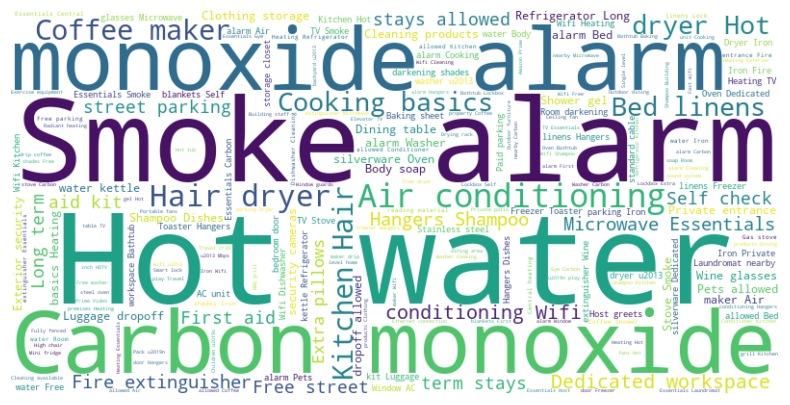

In [16]:
# Create word cloud of amenities
amenities_list = listing['amenities_cleaned'].tolist()
from wordcloud import WordCloud


text = ' '.join(amenities_list)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Airbnb lists the top 10 amenities searched
1. A pool
2. Wifi
3. A kitchen
4. Free parking
5. A hot tub
6. Air conditioning or heating
7. A washer or dryer
8. Self check-in
9. TV or cable
10. A fireplace
https://www.airbnb.com/resources/hosting-homes/a/the-amenities-guests-want-25

In [17]:
# Extract top amenities as binary features
top_amenities = ['pool', 'wifi', 'kitchen', 'free parking', 'hot tub', 'air conditioning|heating', 'washer|dryer', 'self check', 'tv|cable', 'fireplace']

for amenity in top_amenities:
    amenity_col = amenity.split('|')[0].replace(' ', '_')
    listing[amenity_col] = listing['amenities_cleaned'].str.contains(amenity, case=False, na=False)

In [18]:
listing['amenities_score'] = (listing['pool']*1 + listing['wifi']*1 + listing['kitchen']*1+ listing['free_parking']*1+
              listing['hot_tub']*1+listing['air_conditioning']*1+ listing['washer']*1 +listing['self_check']*1+
                 listing['tv']*1 + listing['fireplace']*1) 
print(f'Amenities score statistics:\n{listing["amenities_score"].describe()}')

Amenities score statistics:
count    37529.000000
mean         5.019665
std          1.208730
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         10.000000
Name: amenities_score, dtype: float64


In [19]:
# Exploration on review scores
# It doesn't make sense to fill na as 0. They don't have any reveiws. 
listing[listing['review_scores_rating'].isna()]['number_of_reviews'].sum()

0

In [20]:
# Clean host response and acceptance rates 
# It doesn't make sense to fill na as 0. 
listing['host_response_rate'] = listing['host_response_rate'].str.replace('%','').astype('float')
listing['host_acceptance_rate'] = listing['host_acceptance_rate'].str.replace('%','').astype('float')

In [21]:
# Create binary columns for host and listing details
listing['description_availability'] = np.where(listing['description'].isna(),False,True)
listing['license_available'] = np.where(listing['license'].isna(),False,True)
listing['host_info_availability'] = np.where(listing['host_about'].isna(),False,True)
listing['instant_bookable'] = np.where(listing['instant_bookable'] == 'f',False,True)
listing['host_is_superhost'] = np.where(listing['host_is_superhost']== 'f',False,True)
listing['host_has_profile_pic'] = np.where(listing['host_has_profile_pic']== 'f',False,True)
listing['host_identity_verified'] = np.where(listing['host_identity_verified'] == 'f',False,True)

In [22]:
# Analyze short-term rental percentage
listing['short_term'] = listing['minimum_nights'] < 30
short_term_percentage = listing['short_term'].value_counts(normalize=True) * 100
print(f'Short-term rental percentage:\n{short_term_percentage}')

Short-term rental percentage:
short_term
False    86.141384
True     13.858616
Name: proportion, dtype: float64


In [23]:
# Convert date to numerical length for analysis
current_date = pd.to_datetime('2024-09-05')
listing['first_review_days'] = ((current_date - listing['first_review']).dt.days)
listing['last_review_days'] = ((current_date - listing['last_review']).dt.days)
listing['host_since_year'] = ((current_date - listing['host_since']).dt.days/365.25).round(2)

In [24]:
# Merge calendar and listing data
calendar_price = calendar_df[['listing_id','price']].drop_duplicates()
df_price = listing.merge(calendar_price, left_on='id', right_on='listing_id')

# Outlier Identification

In [25]:
df_price.shape

(37525, 67)

In [26]:
df_price.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,maximum_nights,availability_30,availability_60,...,host_response_rate,host_acceptance_rate,calculated_host_listings_count,bathrooms_cnt,amenities_score,first_review_days,last_review_days,host_since_year,listing_id,price
count,3.752500e+04,37525.000000,37525.000000,37525.000000,22779.000000,37525.000000,37525.000000,3.752500e+04,37525.000000,37525.000000,...,22633.000000,23217.000000,37525.000000,37525.000000,37525.000000,25994.000000,25994.000000,37520.000000,3.752500e+04,37525.000000
mean,3.782099e+17,40.728733,-73.946984,2.760640,1.184841,1.169860,28.981905,5.834113e+04,8.397255,20.004877,...,91.065082,78.149244,56.191765,1.169114,5.019987,1651.423175,823.650035,7.530984,3.782099e+17,382.333723
min,2.595000e+03,40.500366,-74.251907,1.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.010000,2.595000e+03,10.000000
25%,2.063928e+07,40.688503,-73.983108,2.000000,1.000000,1.000000,30.000000,1.500000e+02,0.000000,0.000000,...,96.000000,69.000000,1.000000,1.000000,4.000000,634.000000,65.000000,4.850000,2.063928e+07,77.000000
50%,4.865825e+07,40.726100,-73.954540,2.000000,1.000000,1.000000,30.000000,3.650000e+02,0.000000,3.000000,...,100.000000,90.000000,2.000000,1.000000,5.000000,1381.000000,354.000000,8.130000,4.865825e+07,130.000000
75%,8.447048e+17,40.762390,-73.927790,4.000000,1.000000,1.000000,30.000000,1.125000e+03,18.000000,43.000000,...,100.000000,100.000000,8.000000,1.000000,6.000000,2588.000000,1634.000000,10.200000,8.447048e+17,225.000000
max,1.237702e+18,40.911390,-73.713650,16.000000,15.500000,16.000000,1250.000000,2.147484e+09,30.000000,60.000000,...,100.000000,100.000000,876.000000,15.500000,10.000000,5582.000000,4865.000000,16.070000,1.237702e+18,100000.000000
std,4.642987e+17,0.056343,0.054604,1.926275,0.537593,1.000497,30.715427,1.108634e+07,11.871351,24.140859,...,22.942415,28.421660,170.631857,0.500328,1.208194,1182.390567,991.789680,3.605566,4.642987e+17,1913.826964


price, minimum_nights, maximum_nights & last_review_days are more important to check outliers. 
They can also help indetify any fake listings or inactive listings.

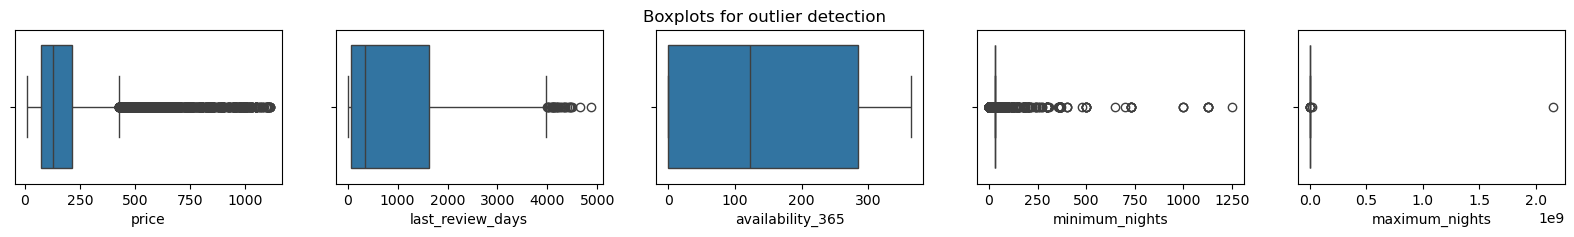

In [55]:
# Plot a boxplot for each feature
fig, axes = plt.subplots(1,5,figsize=(20, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0],x=df_price['price'])
sns.boxplot(ax=axes[1],x=df_price['last_review_days'])
sns.boxplot(ax=axes[2],x=df_price['availability_365'])
sns.boxplot(ax=axes[3],x=df_price['minimum_nights'])
sns.boxplot(ax=axes[4],x=df_price['maximum_nights'])

plt.show()

All the above features have outliers, especially on the upper threshold.

In [28]:
# Outlier Detection Function
def outlier_identifier(col, iqr_factor=1.5):
    '''
    Detect the upper-limit values in specified columns based on their interquartile range.
    Arguments:
    col: column name
    iqr_factor: A number representing x in the formula: 
                Q3 + (x * IQR). Used to determine maximum threshold,
                beyond which a point is considered an outlier.
    '''
    q1 = df_price[col].quantile(0.25)
    q3 = df_price[col].quantile(0.75)
    iqr = q3 - q1
    upper_threshold = q3 + iqr_factor * iqr
    return upper_threshold

High Values for `price`

The maximum `price` in this dataset is `$100,000` per night, which is highly unlikely for typical Airbnb listings. Using the standard formula for outlier detection, \( Q3 + (1.5 \times IQR) \), we obtain a threshold of `$447.0`. However, this value seems low for a maximum price cap in NYC, where premium properties can command much higher rates.

To better reflect realistic high-end prices while controlling outliers, we’ll use a more lenient factor of 6. This adjustment results in a more appropriate cap of `$1,113.0` for our analysis. Prices above this threshold will be considered outliers and handled accordingly.

In [29]:
df_price['price'].describe()

count     37525.000000
mean        382.333723
std        1913.826964
min          10.000000
25%          77.000000
50%         130.000000
75%         225.000000
max      100000.000000
Name: price, dtype: float64

In [30]:
print(f"price upper_threshodld using factor 1.5: {outlier_identifier('price',1.5)}")
print(f"price upper_threshodld using factor 6: {outlier_identifier('price',6)}")

upper_threshodld using factor 1.5: 447.0
upper_threshodld using factor 6: 1113.0


In [31]:
print(f"% of price outside upper limit: {df_price[df_price['price']>1113.0].shape[0]/df_price.shape[0]*100}")

% of price outside upper limit: 2.0972684876748837


2% is relatively insignificant.

In [32]:
# remove price outliers from the dataset
df_price = df_price[df_price['price']<=1113.0]

### Identifying Inactive Airbnb Listings

Airbnb listings that show no availability for an entire year or more in the future can be indicative of hosts who have intentionally blocked off their calendars or properties already rented out as long-term stays. To identify such potentially inactive listings, we can use a combination of the following features:

1. **`last_review_days`**: The number of days since the last review was posted. A high value may indicate that the listing has not had recent activity or bookings.
2. **`availability_365`**: The number of days the listing is available in the next 365 days. If this value is `0`, it suggests that the listing has no availability for the upcoming year. 34% of listings in the dataset do not have availbility in 365 days. 
3. **`maximum_nights`**: The maximum number of nights the property can be rented for. Listings with very high values here might indicate they are set up intentionally as a placeholder or are not intended for typical short-term use.
4. **`numer_of_review`**: The number of reviews is 0 indicating there's no recorded reviews.

### Strategy for Identifying Inactive Listings
1. **Impute Extreme `Maximum Nights` Values**: Impute extreme values in the `maximum_nights` column to a reasonable cap to avoid skewing the analysis. This ensures that extreme outliers in the `maximum_nights` column do not distort our evaluation.

2. **Filter Listings**: A listing is flagged as potentially inactive if:
  - `availability_365` = 0 (no availability for the next 365 days.) **AND**
  - `last_review_days` > `maximum_nights` (no recent reviews despite not being reserved for long-term stays) **OR**
  - `maximum_nights` < 365 for listings with no reviews (`numer_of_review` = 0): The absence of reviews combined with availability_365 = 0 could indicate inactivity. If maximum_nights is set to 365 or higher, the listing could be intended for long-term stays, potentially explaining why it has no reviews even though it shows no availability for the next year.

This approach helps identify listings that are likely inactive, filtering out those legitimately occupied by long-term renters.

In [60]:
print(f"% of no availability in next 365 days: {df_price[df_price['availability_365'] == 0].shape[0]/df_price.shape[0]*100}")

% of no availability in next 365 days: 34.296913277805


High Values for `maximum_nights`

The `maximum_nights` column contains unusually high values, with the maximum recorded at `2147483647` days. This extreme value is likely set intentionally as a placeholder or default and does not reflect realistic data. While it is reasonable for `maximum_nights` to be a large number, such outliers can skew analysis results.

To address this, we need to impute these high values with a more reasonable threshold to control the impact of outliers. Using the standard formula for outlier detection, \( Q3 + (1.5 \times IQR) \), we derive a threshold of `2602.5` days, which equates to nearly 7 years. For analytical purposes, imputing any `maximum_nights` value above this threshold to `2602` days will ensure a more balanced dataset without distorting analysis insights.


In [68]:
df_price['maximum_nights'].max()

2147483647

In [69]:
print(f"max nights upper_threshodld using factor 1.5: {outlier_identifier('maximum_nights',1.5)}")

max nights upper_threshodld using factor 1.5: 2602.5


In [88]:
df_price.loc[df_price['maximum_nights']>2602,'maximum_nights'] = 2602

In [90]:
outdated_reviews = df_price[(df_price['last_review_days']>df_price['maximum_nights']) & (df_price['availability_365'] == 0)]['id']

In [80]:
no_review = df_price[(df_price['number_of_reviews']==0) & (df_price['availability_365'] == 0) & (df_price['maximum_nights']<365)]['id']

In [96]:
df_price = df_price[(~df_price['id'].isin(outdated_review)) | (~df_price['id'].isin(no_review))]

In [102]:
df_price[df_price['amenities_score'] == 0]

,id,name,listing_url,description,neighborhood_overview,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,...,amenities_score,description_availability,license_available,host_info_availability,short_term,first_review_days,last_review_days,host_since_year,listing_id,price
5,53190949,Nice cozy short stay.,https://www.airbnb.com/rooms/53190949,You will be comfortable in this spacious and u...,NaN,Brownsville,Brooklyn,40.664178,-73.911589,Private room,...,0,True,False,True,False,NaN,NaN,4.20,53190949,54.0
28,651593916026998398,Cheerful one bedroom townhouse with backyard,https://www.airbnb.com/rooms/651593916026998398,Have the best of both worlds: Relax and forget...,NaN,Flatlands,Brooklyn,40.624760,-73.935560,Private room,...,0,True,False,False,False,NaN,NaN,7.20,651593916026998398,159.0
53,4920338,1BR 1B FULLY FURNISHED #8783,https://www.airbnb.com/rooms/4920338,NaN,NaN,Upper East Side,Manhattan,40.764020,-73.959160,Entire home/apt,...,0,False,False,False,False,NaN,NaN,9.69,4920338,310.0
94,7539610,"Private room, shared bathroom.",https://www.airbnb.com/rooms/7539610,"Beautiful, sun-filled, furnished condo (new co...",NaN,Harlem,Manhattan,40.820340,-73.943450,Private room,...,0,True,False,True,False,NaN,NaN,9.12,7539610,200.0
122,12426778,TH BRKLYN,https://www.airbnb.com/rooms/12426778,TH BRKLYN,NaN,Boerum Hill,Brooklyn,40.688340,-73.986010,Private room,...,0,True,False,False,False,NaN,NaN,11.09,12426778,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35674,5833530,Shared Room in Apartment,https://www.airbnb.com/rooms/5833530,Furnished apartment in Bed-Stuy on the first f...,NaN,Bedford-Stuyvesant,Brooklyn,40.686380,-73.920320,Private room,...,0,True,False,False,False,NaN,NaN,9.44,5833530,40.0
35777,6388315,UPPER WEST SIDE one bedroom apt,https://www.airbnb.com/rooms/6388315,Bright spaciuos one bedroom in historical town...,NaN,Upper West Side,Manhattan,40.777520,-73.977700,Entire home/apt,...,0,True,False,False,False,NaN,NaN,10.84,6388315,120.0
37208,5251719,1 Bedroom in Luxury Wall street Apt,https://www.airbnb.com/rooms/5251719,"1 br in large 2 br apt in financ. dist., queen...",famous bull in financial district<br />stock e...,Financial District,Manhattan,40.704110,-74.007950,Shared room,...,0,True,False,False,False,NaN,NaN,9.59,5251719,75.0
37236,4785563,Holiday Sublet in Carroll Gardens,https://www.airbnb.com/rooms/4785563,A Brooklyn Home for the Holidays! Welcome to o...,"Many wonderful restaurants, bars, and shops ar...",Carroll Gardens,Brooklyn,40.677250,-73.999680,Private room,...,0,True,False,True,False,NaN,NaN,12.46,4785563,100.0


In [99]:
df_price.shape

(29220, 67)

In [ ]:
df_price.columns

In [100]:
listing_tableau = df_price[['id', 'name', 'listing_url', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'bathrooms_cnt', 'short_term', 
       'amenities_score',  'price','availability_30', 'availability_60', 'availability_90',
       'availability_365',
       'number_of_reviews','first_review_days', 'last_review_days', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_id', 'host_since','host_since_year', 'host_response_time', 'host_response_rate', 
        'host_acceptance_rate','instant_bookable', 'host_is_superhost', 'host_verifications',
       'license', 'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count', 'host_info_availability']]

In [101]:
listing_tableau.to_excel('listing.xlsx',index=False )

In [ ]:
df_lm = df_price[['description_availability','neighbourhood_group_cleansed',  
        'room_type', 'accommodates', 'short_term', 
       'amenities_score',  'price','number_of_reviews', 
    'review_scores_rating',  'host_response_rate', 'host_acceptance_rate','instant_bookable', 
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_info_availability']]

In [ ]:
df_lm.info()

In [ ]:
df_lm = pd.get_dummies(df_lm, columns=['neighbourhood_group_cleansed','room_type'], prefix=['neighbourhood_group_cleansed','room_type'])


In [ ]:
correlation_matrix = df_lm.corr(method='pearson')
print(correlation_matrix)

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

## Exploratory Data Analysis

## Visualization of Key Insights

## Conclusion

### Conclusion
Through this analysis, we discovered trends in Airbnb listings' prices and availability across various neighborhoods in New York City. The insights can assist hosts in setting competitive prices and managing availability to maximize occupancy. Future analyses could incorporate guest review sentiments or compare seasonal trends to deepen these insights.